<a href="https://colab.research.google.com/github/deltorobarba/science/blob/main/schroedinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Simulating Quantum Time Evolution with Time-Dependent Schrödinger**

In [ ]:
!pip install cirq openfermion -q
import cirq
import numpy as np
import matplotlib.pyplot as plt

###### Overview

<font color="blue">**Description of Quantum Systems: Classical vs Quantum Methods**

Quantum systems in chemistry and physics can be described and computed with either classical and quantum methods:

* **Model**: Classical (Newton Mechanics) vs Quantum (Schrödinger equation)
* **Type**: Static (State) vs Dynamical (Evolution)
* **Computing**: Classical Computing vs Quantum Computing

<font color="blue">*1. Classical (Newtonian) Mechanics (**Static and Dynamic**): $F = m \cdot a$*
* Ignores electrons and consider atoms as spheres connected by springs (force fields)
* **Classical - Dynamic**: Molecular dynamics (MD). How proteins enfold and move? GROMACS, NAMD, AMBER.
* **Classical - Static**: Molecular Docking / Energy Minimization. Geometrically: Does medication fit to enzyme? AutoDock, Rosetta.
* **Quantum computing methods:** Future: Navier Stokes (fluid dynamics) with HHL to solve linear systems and differential equations exponentially faster than classical computers. For weather and climate: simulate weather with a much finer grid (e.g. 100m)

<font color="blue">*2. Quantum Mechanics (**Static**): Time-independent Schrödinger Equation $\hat{H}|\psi\rangle = E|\psi\rangle$*
* Includes electrons. **Approximates Ground State via optimization** with variation $\delta \langle H \rangle = 0$ to find global optimum in energy landscape. Stationary state important for calculating binding energies: If $\psi$ is an eigenstate of $\hat{H}$, then time evolution is trivial: $\Psi(t) = \psi e^{-iEt/\hbar}$. Probability density $|\Psi(t)|^2$ remains constant over time = states are stationary.
* **Classical computing:** Hartree-Fock (mean field of $\psi$), DFT (electron density $\rho$), Post-HF (calculate correlation energies)
* **Quantum computing** (**NISQ**): Variational Quantum Eigensolver. Quantum Advantage: finds correlation energy with entanglement.

<font color="red">*3. Quantum Mechanics (**Dynamic**): Time-dependent Schrödinger Equation $i\hbar \frac{\partial}{\partial t} \Psi(\mathbf{r}, t) = \hat{H} \Psi(\mathbf{r}, t)$*
* **Simulate Time Evolution** $e^{-i\hat{H}t}$ of Quantum State $|\Psi(t)\rangle = e^{-i\hat{H}t/\hbar} |\Psi(0)\rangle$ via Unitary Transformation. For Quantum Chaos, OTOC, Scrambling (Black Holes) reaction dynamics (observe how bonds break and reform during a collision). No forward theorem!
* **Classical computing**: Time-Dependent DFT (TD-DFT) used to classically calculate excitations (fluorescence, spectra). However only for short times and small systems. To solve the time-dependent equation $i\hbar \frac{\partial}{\partial t} \Psi = \hat{H} \Psi$ classically at scale, you have to apply operator $e^{-i\hat{H}t/\hbar}$ to wavefunction. In system with $N$ particles, complexity grows exponentially with $N$.
* **Quantum computing** (**Fault-Tolerant**): LCU, Trotterization, Qubitization (with Quantum Walks and Block Encoding)

<font color="blue">*Appendix: Wy we can solve the Schrödinger equation analytically only for very small systems*

* **Analytical** solution for Schrödinger in Hydrogen atom. But a second electron add electron-electron repulsion = three-body problem.
* **Approximate** Schrödinger with DFT and HF on classical computers via **optimization (variation)** for larger systems than Hydrogen
* **Simulate** time evolution for even larger systems = Quantum computer doesn't store information anymore - **it is the Hilbert space!**


###### Methods

<font color="blue">**Trotter-Suzuki Decomposition (Product Formulas)**</font>

* **Trotter**. Strategy: Product Approximation. Scaling (Precision): Polynomial ($1/\epsilon^p$). Hardware Requirements: Low (NISQ-friendly)
* Based on approximating the propagator by decomposing the Hamiltonian into commuting fragments. Since $[\hat{T}, \hat{V}] \neq 0$, it follows that $e^{-i(\hat{T}+\hat{V})t} \neq e^{-i\hat{T}t}e^{-i\hat{V}t}$.  The first-order Trotter-Suzuki formula utilizes the limit: $e^{-i\hat{H}t} = \lim_{n \to \infty} \left( \prod_j e^{-i\hat{h}_j t/n} \right)^n$
* A molecule evolves under all its forces (Kinetic + Potential) simultaneously, but quantum computer can is digital and cannot do at once. Solution: Hamiltonian $\hat{H} = \sum \hat{h}_j$ is divided into small time steps $\Delta t = t/n$. In each step, every term is applied individually = in each step it switches between forces: $e^{-i(H_{int} + H_{field})t} \approx \left( e^{-i H_{int} \Delta t} \cdot e^{-i H_{field} \Delta t} \right)^n$ (interaction/entanglement and transverse field).
* Ising ($H = Z_0 Z_1 + X_0 + X_1$): **Interaction** ($Z_0 Z_1$): align/anti-align spins (Entanglement). **Transverse Field** ($X$): flip spins (Dynamics). Partial propagators implemented as gates since they represent natural rotations of form $e^{-i \theta P}$ ($P$ = Pauli operator):
  * **$ZZ$-Interaction:** $e^{-i Z \otimes Z \theta}$ operator is not natively available on QC. Constructed (synthesized) with sequence: CNOT $\rightarrow$ RZ $\rightarrow$ CNOT. Cirq offers the `ZZPowGate`. More compact, but careful with conversion: `ZZPowGate` with exponent $e$ performs operation $\exp(-i \frac{\pi}{2} e Z \otimes Z)$. However, we want $\exp(-i \cdot dt \cdot Z \otimes Z)$. Setting them equal: $\frac{\pi}{2} e = dt \, \Rightarrow \, e = \frac{2 \cdot dt}{\pi}$
  * **$X$-Rotation:** (Transverse field $X$). term $e^{-i X \theta}$ corresponds exactly to an RX gate.
* **Code**: Unified Trotter Simulation (Ising Model Hamiltonian: $H = J \cdot (Z_0 Z_1) + B \cdot (X_0 + X_1)$)
  * Case 1 (Time Evolution): set $J=1, B=1$ and watch how states $|00\rangle$ and $|11\rangle$ evolve.
  * Case 2 (Regime Change): vary $J$ and $B$ to see "Rabi Oscillations" vs. "Interaction Blockade".
* **Limitation**: error scales quadratically with the step size ($O(\Delta t^2)$ for 1st order). For high-precision long-time studies (e.g., Quantum Chaos), Trotter requires an extremely high number of gates, which often leads to terminal decoherence on NISQ.
* **Next Steps**: (1) Calculate the Trotter error. (2) Implement second-order Suzuki-Trotter.


--- Circuit Logic Verification ---

Structure for J=1, B=1 (Standard - Full Interaction):
0: ───@────────────────@───Rx(0.064π)───
      │                │
1: ───X───Rz(0.064π)───X───Rx(0.064π)───

Structure for J=0, B=1 (Field Only - No CNOTs):
0: ───Rx(0.064π)───

1: ───Rx(0.064π)───
Running Simulation for J=1.0, B=1.0...
Running Simulation for J=0.0, B=1.0...
Running Simulation for J=5.0, B=1.0...


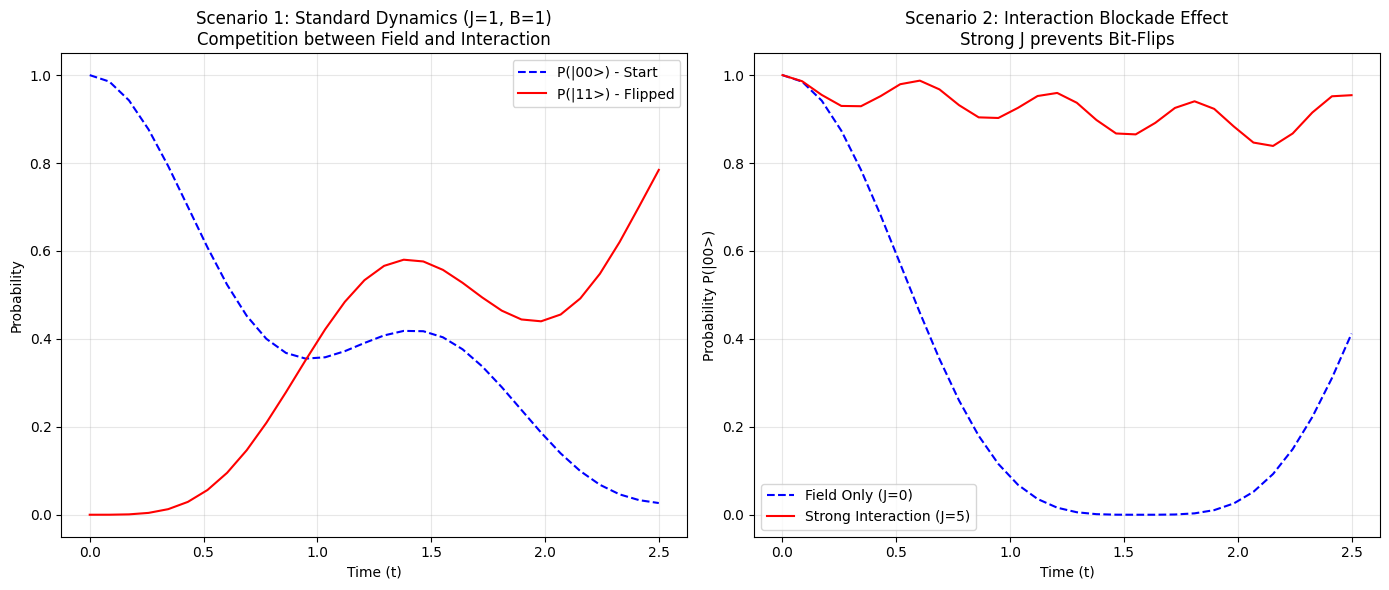

In [ ]:
# ==========================================
# TROTTERIZATION (Suzuki-Trotter)
# ==========================================

# 1. GENERAL PHYSICS ENGINE

# Generates single time-slice (Trotter step). Simulates Hamiltonian: H = J * (Z0 Z1) + B * (X0 + X1)
def generate_trotter_step(qubits, dt, J, B):
    """
    qubits: List of qubits to simulate.
    dt: size of time step.
    J: Strength of Interaction (Entanglement).
    B: Strength of Transverse Magnetic Field (Dynamics).
    """
    n = len(qubits)

    # --- Part A: Interaction Terms (ZZ) - "Entangler" ---
      # Target Physics: exp(-i * J * Z * Z * dt)
      # Problem: Quantum computers don't have a native "ZZ" gate.
      # Solution: synthesize it using a "Gadget": CNOT -> Rz -> CNOT.
      # Logic: If J=0, the qubits don't interact, so skip these gates
    if J != 0:
        for i in range(n - 1):
            # 1. Compute Parity (store result in second qubit)
            yield cirq.CNOT(qubits[i], qubits[i+1])

            # 2. Add Phase (proportional to interaction energy J)
            # Rz(phi) = exp(-i * Z * phi/2). Want exp(-i * J * dt * Z). So phi/2 = J*dt  ->  phi = 2*J*dt
            yield cirq.rz(rads=2 * J * dt).on(qubits[i+1])

            # 3. Uncompute Parity (restore basis)
            yield cirq.CNOT(qubits[i], qubits[i+1])

    # --- Part B: Transverse Field Terms (X) - The "Rotator" ---
      # Target Physics: exp(-i * B * X * dt)
      # corresponds exactly to a Rotation around X-axis (Rx gate).
      # Logic: If B=0, the magnetic field is off, skip rotation.
    if B != 0:
        for i in range(n):
            # Rx(theta) = exp(-i * X * theta/2). Want exp(-i * B * dt * X). So theta = 2*B*dt.
            yield cirq.rx(rads=2 * B * dt).on(qubits[i])

# Hyperparameters
num_qubits = 2
t_max=2.5 # simulation_time
steps=30 # trotter steps

# Simulates the system from t=0 to t_max. Returns probabilities of finding system in |00> or |11>
def get_probabilities_over_time(J, B, t_max=t_max, steps=steps):
    qubits = cirq.LineQubit.range(num_qubits)
    time_points = np.linspace(0, t_max, steps)
    probs_00 = []
    probs_11 = []
    print(f"Running Simulation for J={J}, B={B}...")

    for t in time_points:
        circuit = cirq.Circuit()

        # Build Time Evolution Circuit. Divide total time 't' into n smaller Trotter steps
        # to ensure approximation holds (dt must be small).
        if t > 0:
            dt = t / 10
            for _ in range(10):
                circuit.append(generate_trotter_step(qubits, dt, J, B))

        # --- Simulation ---
        simulator = cirq.Simulator()

        # Explicitly provide 'qubit_order' to force a 2-qubit simulation
        # even if circuit is empty (at t=0) or has disconnected qubits.
        result = simulator.simulate(circuit, qubit_order=qubits)

        # --- Measurement ---
        # result.final_state_vector returns amplitudes [a00, a01, a10, a11]. Probability = |amplitude|^2
        probs_00.append(np.abs(result.final_state_vector[0])**2) # Index 0 is |00>
        probs_11.append(np.abs(result.final_state_vector[3])**2) # Index 3 is |11>

    return time_points, probs_00, probs_11

# 2. VISUALIZE CIRCUIT
print("--- Circuit Logic Verification ---")

# Demo 1: Full Hamiltonian (Standard Case). Expectation: CNOTs are present (Interaction is ON)
qubits_demo = cirq.LineQubit.range(num_qubits)
circuit_full = cirq.Circuit(generate_trotter_step(qubits_demo, dt=0.1, J=1.0, B=1.0))
print("\nStructure for J=1, B=1 (Standard - Full Interaction):")
print(circuit_full)

# Demo 2: Field Only. Expectation: CNOTs are MISSING (Interaction is OFF). Circuit is smaller.
circuit_field = cirq.Circuit(generate_trotter_step(qubits_demo, dt=0.1, J=0.0, B=1.0))
print("\nStructure for J=0, B=1 (Field Only - No CNOTs):")
print(circuit_field)

# 3. SIMULATION RESULTS
plt.figure(figsize=(14, 6))

# === Subplot 1: Detailed Dynamics (Balanced Forces) ===
  # The Field tries to flip qubits, the Interaction tries to align them.
  # Result: Complex oscillation (Superposition).
plt.subplot(1, 2, 1)
times, p00, p11 = get_probabilities_over_time(J=1.0, B=1.0)
plt.plot(times, p00, label='P(|00>) - Start', color='blue', linestyle='--')
plt.plot(times, p11, label='P(|11>) - Flipped', color='red')
plt.title("Scenario 1: Standard Dynamics (J=1, B=1)\nCompetition between Field and Interaction")
plt.xlabel("Time (t)")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, alpha=0.3)

# === Subplot 2: Parameter Sweep (Comparison) ===
plt.subplot(1, 2, 2)
# Case A: Field Only (J=0): Pure Rabi Oscillations. Qubits rotate cleanly |0> -> |1> -> |0>.
t_a, p00_a, _ = get_probabilities_over_time(J=0.0, B=1.0)
plt.plot(t_a, p00_a, label='Field Only (J=0)', color='blue', linestyle='--')
# Case B: Strong Interaction (J=5): Interaction Blockade / Quantum Zeno Effect.
# energy cost to flip is too high. system is "frozen" in |00>
t_b, p00_b, _ = get_probabilities_over_time(J=5.0, B=1.0)
plt.plot(t_b, p00_b, label='Strong Interaction (J=5)', color='red')
plt.title("Scenario 2: Interaction Blockade Effect\nStrong J prevents Bit-Flips")
plt.xlabel("Time (t)")
plt.ylabel("Probability P(|00>)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<font color="blue">**Linear Combination of Unitaries (LCU)**</font>

* **LCU**. Strategy:  Taylor Series Sum. Scaling (Precision): Logarithmic ($\log(1/\epsilon)$).Hardware Requirements:  Medium (Ancillas required)
* **Taylor Series Evolution:** expand the propagator $e^{-iHt}$ as a power series: $1 - iHt - \frac{1}{2}H^2t^2 \dots$. Each term in this series is a product of unitaries (which is also a unitary). Use LCU to sum these terms directly. This simulates time evolution.
* LCU is the "Intellectual Opposite" of Trotterization and  theoretical foundation for advanced fault-tolerant algorithms:
  * **Trotterization:** Slices the operator in **Time** (Sequence of gates).
  * **LCU:** Slices the operator in **Amplitude** (Parallel superposition).
  * **Tradeoff**: trade **time** (circuit depth) for **space** (ancilla qubits).
* **Application to Time Evolution:** propagator $e^{-iHt}$ is decomposed into an LCU form using its Taylor series expansion.
  * Rather than "chopping" exponential function, it represents it directly as a sum of unitaries.
  * Express a (not necessarily unitary) operator $A$ as a weighted sum of simple unitaries $U_l$: $A = \sum_{l=0}^{L-1} \alpha_l U_l, \quad \alpha_l > 0$
  * **Trade-offs:** LCU has better error scaling than Trotter but requires additional ancilla qubits + complex controlled operations.
* **Concept: "Mixing Desk"**: Apply operator $H = 0.5 X + 0.5 Z$. Apply X and then Z would be product $X \cdot Z$, not **sum**. LCU mixes:
  1. **PREPARE Oracle (Ancilla State):** Create superposition on auxiliary qubit (Ancilla) that encodes coefficients $\sqrt{\alpha_l}$. Amplitudes control "how much" of X and "how much" of Z it gets. `cirq.H(q_ancilla)`. This encodes the coefficients $\alpha_k$ of the Hamiltonian $H = \sum \alpha_k U_k$. If you wanted $H = 0.8 X + 0.6 Z$, you wouldn't use a Hadamard; you would use an $R_y(\theta)$ rotation to create a state $\sqrt{0.8}|0\rangle + \sqrt{0.6}|1\rangle$.
  2. **SELECT Oracle (Controlled Operations):** Entanglement: applies unitary $U_l$ to system register (data), conditioned on state of ancilla register (instructions: If Ancilla is 0, apply X. If Ancilla is 1, apply Z). This encodes operators $U_k$ (Pauli terms).
  3. **UN-PREPARE & MEASURE (Projection):** interfere branches back together. Measure Ancilla in $|0\rangle$ guarantees that sum $(X+Z)$ is applied. But: We decompose result into "Success State" (Ancilla $|0\rangle$) and "Junk State" (Ancilla $|1\rangle$). LCU is non-deterministic. Success Probability of measuring e.g. 0 can be 50%. Solution: 'Oblivious Amplitude Amplification' technique to make deterministic (rotate probability towards 100%)
* **LCU is foundation of Qubitization, but LCU be used on its own.**. Qubitization relies on **Block Encoding**, which requies LCU: Decompose Hamiltonian into sum of Paulis: $H = \sum \alpha_l P_l$. Then use LCU oracles (**PREPARE** and **SELECT**) to create the unitary $U$ that contains $H$. Without LCU structure, there is no "Walk Operator" that Qubitization needs.
* **Code**: Simulate $H = \frac{1}{2}(X + Z)$. Apply $A = \frac{X + Z}{2}$ to qubit $|0\rangle$. $X|0\rangle = |1\rangle$. $Z|0\rangle = |0\rangle$. Target Result: $\frac{1}{2}(|1\rangle + |0\rangle) \propto |+\rangle$

In [ ]:
# ==========================================
# LCU (Linear Combination of Unitaries)
# ==========================================

def LCU_demonstration():
    # 1. Hardware Setup: 'Ancilla' to control the sum, and a 'System' qubit to act on.
    q_ancilla = cirq.NamedQubit("Ancilla")
    q_system = cirq.NamedQubit("System")

    circuit = cirq.Circuit()

    # --- STEP 1: PREPARE (The Coefficients) ---
    # We want coefficients 0.5 * X + 0.5 * Z.
    # We use a Hadamard on the ancilla to create equal superposition:
    # |0> -> 1/sqrt(2) (|0> + |1>)
    # This sets equal weight for both branches.
    circuit.append(cirq.H(q_ancilla))

    # --- STEP 2: SELECT (The Unitaries) ---
    # This is the "multiplexer".
    # If Ancilla is 0 -> Apply X
    # If Ancilla is 1 -> Apply Z

    # Branch 0: Controlled-X (activated when Ancilla is 0)
    circuit.append(cirq.X(q_system).controlled_by(q_ancilla, control_values=[0]))

    # Branch 1: Controlled-Z (activated when Ancilla is 1)
    circuit.append(cirq.Z(q_system).controlled_by(q_ancilla, control_values=[1]))

    # --- STEP 3: UN-PREPARE (Interference) ---
    # We must close the interference loop to combine the paths.
    # Inverse of Prepare (H^-1 = H).
    circuit.append(cirq.H(q_ancilla))

    # --- STEP 4: POST-SELECTION ---
    # LCU is probabilistic. It only works if the Ancilla returns to |0>.
    # If Ancilla is |1>, the operation failed (we applied X-Z instead of X+Z).
    circuit.append(cirq.measure(q_ancilla, key='ancilla_measure'))

    # --- Simulation ---
    print("Circuit Structure:")
    print(circuit)

    simulator = cirq.Simulator()
    # We simulate the state vector.
    # Note: In real life, we would discard runs where ancilla_measure == 1.
    result = simulator.simulate(circuit)

    # Let's check the final state vector
    final_state = result.final_state_vector

    # Extract the part of the vector where Ancilla is |0> (The Success branch)
    # The state vector has 4 entries: |00>, |01>, |10>, |11> (Ancilla, System)
    # We care about |00> and |01>.
    amplitude_00 = final_state[0] # Ancilla=0, System=0
    amplitude_01 = final_state[1] # Ancilla=0, System=1

    print("\n--- Results (Success Branch: Ancilla = 0) ---")
    print(f"Amplitude |0>: {amplitude_00:.4f}")
    print(f"Amplitude |1>: {amplitude_01:.4f}")

    # Check if it matches our expectation: proportional to |+> = (|0> + |1>)
    print("\nInterpretation:")
    if np.isclose(amplitude_00, amplitude_01):
        print("SUCCESS: The system is in state |+> (|0> + |1>).")
        print("We successfully applied (X + Z) / 2.")
    else:
        print("Failed.")

LCU_demonstration()

Circuit Structure:
Ancilla: ───H───(0)───@───H───M('ancilla_measure')───
                │     │
System: ────────X─────@──────────────────────────────

--- Results (Success Branch: Ancilla = 0) ---
Amplitude |0>: 0.7071+0.0000j
Amplitude |1>: 0.7071+0.0000j

Interpretation:
SUCCESS: The system is in state |+> (|0> + |1>).
We successfully applied (X + Z) / 2.


<font color="blue">**Qubitization (Quantum Walks & Block Encoding)**</font>

* **Qubitization**. Strategy: Unitary Embedding. Scaling (Precision): Logarithmic ($\log(1/\epsilon)$). The complexity scales linearly with time $t$ and only logarithmically with the desired precision $1/\epsilon$. This represents an exponential improvement over Trotter regarding accuracy Hardware Requirements:  High (fault-toleran QC)
* Instead of calculating $e^{-iHt}$ directly, one constructs a **Quantum Walk** operator $Q$ through a combination of reflection operators and the block encoding of $\hat{H}$. Energy Mapping: eigenvalues of $Q$ are linked to eigenvalues $E$ of Hamiltonian via $\mu = e^{\pm i \arccos(E/\lambda)}$.
* Steps and Components of Qubitization:
  1. **Pauli Decomposition of Operator:** Writing $H$ as a sum. $H = \sum \alpha_k U_k$. (Non-unitary, represents Energy). Operators can be Hamiltonian or Dirac operator or else. But Dirac operator $\mathcal{D}$ (or spin chains) is often used as benchmark because its algebraic structure (sum of Paulis) allows for highly efficient block encoding.
  2. **Normalization:** $\lambda = \sum |\alpha_k|$. We encode $H/\lambda$.
  3. **LCU Oracles:** Defining **PREPARE** (coefficients) and **SELECT** (operators).
  4. **Block Encoding ($U$):** A unitary matrix where the top-left block is $H/\lambda$. Using those oracles to put $H$ in the corner of a big Unitary. Hamiltonian $\hat{H}$ is embedded (**block-encoded**) into a larger unitary matrix $U_H$ such that $\hat{H}$ appears in upper-left block: $U_H = \begin{pmatrix} \hat{H}/\lambda & \dots \\ \dots & \dots \end{pmatrix}$. Physical View:* If the Ancilla is $|0\rangle$, we effectively apply $H$. If the Ancilla is $|1\rangle$, we apply "junk".
  5. **Quantum Walk Operator ($Q$):** A unitary made from Reflections and $U$. Adding **Reflections** to that Unitary $U$ to turn it into a "Walk" that moves through the energy spectrum. By reflecting "junk" back into the system ($Q = R \cdot U$), we create a rotation.
  6. **Result**: Eigenvalues of $Q$ are $e^{\pm i \theta}$. The Physics is hidden in the angle: $E_k = \lambda \cos(\theta_k)$. **Isomorphism:** The Walk transforms **Energy information** (which is a scalar magnitude) into **Phase information** (how fast the walk rotates).
      * High Energy $\rightarrow$ Small Angle. Zero Energy $\rightarrow$ 90-degree Angle ($\cos(90^\circ)=0$).

*When simulating Quantum Chaos, spectral resolution is crucial. While Trotter "blurs" eigenvalues due to approximation errors, Qubitization preserves spectral structure almost perfectly. In Qubitization, quantum computer becomes identical to problem's Hilbert space.*




In [ ]:
# ==========================================
# QUBITIZATION (Linear Algebra Example)
# ==========================================
from scipy.linalg import block_diag

"""
* We simulate $H = 0.6 X + 0.8 Z$.
* Pauli X and Z don't commute.
* We mix them using LCU (Linear Combination of Unitaries).
* Output Interpretation: look at Mapped Energy column.

1. True Energies of $H$ are -1.0 and +1.0.
2. Q-Eigenvalues: Walk Operator $Q$ has 4 eigenvalues.
  * They come in conjugate pairs $e^{+i\theta}$ and $e^{-i\theta}$.
  * Example: If $E = 1.0$ and $\lambda = 1.4$, then $\cos(\theta) = 1.0/1.4 \approx 0.71$.
  * $\theta \approx \pm 0.78$ radians.
3. Result: code will print "Mapped Energy: 1.0000" and "Mapped Energy: -1.0000"
"""

def qubitization_walk_demo():
    print("--- Qubitization / Block Encoding Demo ---")

    # 1. Define the Physics (The Hamiltonian H)
    # H = 0.6 * X + 0.8 * Z
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])

    coeffs = [0.6, 0.8]
    ops = [X, Z]

    # Calculate True Hamiltonian
    H_target = coeffs[0]*ops[0] + coeffs[1]*ops[1]

    # Calculate True Eigenvalues (Energies)
    # We expect E = +/- sqrt(0.6^2 + 0.8^2) = +/- 1.0
    energies_true = np.linalg.eigvalsh(H_target)
    print(f"True Energies of H: {energies_true}")

    # --- 2. Build the Components ---

    # Normalization factor lambda (L1 norm of coeffs)
    lam = sum(coeffs) # 0.6 + 0.8 = 1.4
    print(f"Normalization (lambda): {lam}")

    # A) PREPARE Operator (State Preparation)
    # Maps |0>_a to sqrt(0.6/1.4)|0> + sqrt(0.8/1.4)|1>
    # This is a rotation on the Ancilla.
    # We construct the matrix explicitely as a block matrix acting on Ancilla + System.
    # But PREPARE only acts on Ancilla.

    # Vector state for PREPARE: v = [sqrt(w0), sqrt(w1)]
    w = np.sqrt(np.array(coeffs) / lam)

    # Construct a rotation matrix V where the first column is w
    # V = [[w0, -w1],
    #      [w1,  w0]]
    # (Gram-Schmidt completion)
    V_ancilla = np.array([[w[0], -w[1]],
                          [w[1],  w[0]]])

    # PREPARE acts on Ancilla (2x2) x Identity on System (2x2) -> 4x4 matrix
    PREP = np.kron(V_ancilla, np.eye(2))

    # B) SELECT Operator (The Router)
    # If Ancilla |0> -> Apply X
    # If Ancilla |1> -> Apply Z
    # Matrix form: Block Diagonal [X, 0; 0, Z]
    SELECT = block_diag(X, Z)

    # --- 3. Block Encoding (U) ---
    # The LCU Operator: U = PREP_dag * SELECT * PREP
    # Note: In standard Qubitization, we often use the iterate W = R * U_dag * R * U.
    # Or simply U itself is the block encoding.
    # Let's check the top-left block of U (Ancilla |0> state).

    U_LCU = PREP.T @ SELECT @ PREP

    # Extract Top-Left Block (First 2x2 matrix)
    # This corresponds to projection <0|_a U |0>_a
    # We verify that <0|U|0> = H / lambda
    top_left_block = U_LCU[0:2, 0:2]

    print("\n--- Block Encoding Check ---")
    print("Target (H / lambda):")
    print(H_target / lam)
    print("Implemented (Top-Left of U):")
    print(top_left_block)

    # --- 4. The Walk Operator (Q) ---
    # Qubitization Iterate: Q = (2|0><0|_a - I) * U_LCU
    # Note: U_LCU is Hermitian here because X, Z are Hermitian and coeffs are real.
    # So U_LCU is its own inverse (if unitary) or close to it.
    # Actually, U_LCU constructed above is UNITARY (since PREP and SELECT are unitary).

    # Reflection Operator R = 2|0><0| - I on Ancilla
    # |0><0| on ancilla is: [[1, 0], [0, 0]]
    P0_ancilla = np.array([[1, 0], [0, 0]])
    R_ancilla = 2 * P0_ancilla - np.eye(2)
    R = np.kron(R_ancilla, np.eye(2))

    # The Walk Operator Q
    # Q = R * U_LCU
    Q = R @ U_LCU

    # --- 5. Spectral Analysis ---
    # Eigenvalues of Q should be e^(+/- i theta)
    # where cos(theta) = Energy / lambda

    eigvals_Q, _ = np.linalg.eig(Q)

    print("\n--- Qubitization Spectrum ---")
    for ev in eigvals_Q:
        # 1. Get the angle theta
        theta = np.angle(ev)

        # 2. Map back to Energy: E = lambda * cos(theta)
        energy_est = lam * np.cos(theta)

        print(f"Q-Eigenvalue: {ev:.2f} | Phase: {theta:.2f} rad | -> Mapped Energy: {energy_est:.4f}")

qubitization_walk_demo()

--- Qubitization / Block Encoding Demo ---
True Energies of H: [-1.  1.]
Normalization (lambda): 1.4

--- Block Encoding Check ---
Target (H / lambda):
[[ 0.57142857  0.42857143]
 [ 0.42857143 -0.57142857]]
Implemented (Top-Left of U):
[[ 0.57142857  0.42857143]
 [ 0.42857143 -0.57142857]]

--- Qubitization Spectrum ---
Q-Eigenvalue: 0.71+0.70j | Phase: 0.78 rad | -> Mapped Energy: 1.0000
Q-Eigenvalue: 0.71-0.70j | Phase: -0.78 rad | -> Mapped Energy: 1.0000
Q-Eigenvalue: -0.71+0.70j | Phase: 2.37 rad | -> Mapped Energy: -1.0000
Q-Eigenvalue: -0.71-0.70j | Phase: -2.37 rad | -> Mapped Energy: -1.0000


In [ ]:
# ==========================================
# QUBITIZATION (Quantum Circuit Example)
# ==========================================

"""
Complete quantum circuit implementation of single step of Qubitization Walk operator ($Q$) with all pillars.
1. **PREPARE**: Encodes Hamiltonian coefficients $\alpha_j$  into ancilla amplitudes.
2. **SELECT**: Conditionally applies the unitary components $U_j$ (LCU).
3. **Block Encoding**: combination of $PREP^\dagger \cdot SEL \cdot PREP$ which embeds $H/\lambda$ into a unitary.
4. **Reflection**: operator $(2|0\rangle\langle0| - I)$ turns static block encoding into dynamic Quantum Walk

Missing elements for full production-scale algorithm:
* Iterative Application: For actual energy estimation or time evolution, apply $Q$ operator many times ($Q^n$) in a row.
* Quantum Phase Estimation: To "read out" energy, wrap $Q$ steps in a Phase Estimation circuit
  to extract phase $\theta$, which relates to the energy via $E = \lambda \cos(\theta)$.
* Amplitude Amplification: In some cases, to make the LCU part deterministic.
"""

# Implement the Hamiltonian. Block Encoding of a Hamiltonian—the first step of Qubitization
# --- 1. Define the Oracles ---

class PrepareOracle(cirq.Gate):
    """The PREPARE oracle: Encodes coefficients into the Ancilla."""
    def __init__(self, coeffs):
        super(PrepareOracle, self).__init__()
        self.coeffs = coeffs
        self.l1 = sum(coeffs)
        # Calculate rotation angle: theta = 2 * arccos(sqrt(alpha/lambda))
        self.theta = 2 * np.arccos(np.sqrt(coeffs[0] / self.l1))

    def _num_qubits_(self): return 1

    def _decompose_(self, qubits):
        # This creates the superposition sqrt(0.6/1.4)|0> + sqrt(0.8/1.4)|1>
        yield cirq.ry(self.theta).on(qubits[0])

class SelectOracle(cirq.Gate):
    """The SELECT oracle: Applies X if ancilla is 0, Z if ancilla is 1."""
    def _num_qubits_(self): return 2 # 1 Ancilla + 1 System

    def _decompose_(self, qubits):
        ancilla, system = qubits
        # If Ancilla is |0>, apply X to system
        yield cirq.X(system).controlled_by(ancilla, control_values=[0])
        # If Ancilla is |1>, apply Z to system
        yield cirq.Z(system).controlled_by(ancilla, control_values=[1])

# --- 2. Build the Qubitization Walk ---

def build_qubitization_circuit(coeffs):
    q_anc = cirq.NamedQubit("Ancilla")
    q_sys = cirq.NamedQubit("System")

    circuit = cirq.Circuit()

    # Define Oracles
    PREP = PrepareOracle(coeffs)
    SEL = SelectOracle()

    # A. The LCU Step (Block Encoding)
    # This places H/lambda in the top-left block of the unitary
    circuit.append(PREP.on(q_anc))
    circuit.append(SEL.on(q_anc, q_sys))
    circuit.append(cirq.inverse(PREP).on(q_anc))

    # B. The Reflection (Turning it into a Walk)
    # This is the 'Q' operator we discussed in Numpy
    # Q = (2|0><0| - I) @ U
    circuit.append(cirq.Z(q_anc)) # Simple reflection for 1-qubit ancilla

    return circuit

# --- 3. Execution ---
coeffs = [0.6, 0.8]
l1_norm = sum(coeffs)
circuit = build_qubitization_circuit(coeffs)

print("--- Qubitization Circuit (Single Step) ---")
print(circuit)

# Verification via Simulation
simulator = cirq.Simulator()
result = simulator.simulate(circuit)

# In Qubitization, the Energy is hidden in the Phase:
# Energy = lambda * cos(Phase)
# For H = 0.6X + 0.8Z, the energy is 1.0.
# 1.0 / 1.4 = 0.714 -> arccos(0.714) = 0.775 rad.
print(f"\nFinal State Vector: {np.around(result.final_state_vector, 3)}")

--- Qubitization Circuit (Single Step) ---
Ancilla: ───<__main__.PrepareOracle object at 0x7a692d8cccb0>───<__main__.SelectOracle object at 0x7a692d8b2180>───<__main__.PrepareOracle object at 0x7a692d8cccb0>†───Z───
                                                                │
System: ────────────────────────────────────────────────────────#2──────────────────────────────────────────────────────────────────────────────────────────────────────────

Final State Vector: [ 0.571+0.j  0.429+0.j -0.495+0.j  0.495+0.j]


###### Applications: OTOC, Quantum Chaos and Scrambling

<font color="blue">**Quantum Dynamics: Quantum Chaos, Scrambling and OTOC**

<font color="blue">*1. Phenomenon: Quantum Chaos*

* **Quantum Chaos** how deterministic quantum systems emulate behavior of classical chaotic systems despite linearity of Schrödinger. Unlike classical chaos (sensitivity to initial conditions), Quantum Chaos is defined by the statistics of the energy eigenvalues (Energy Level Statistics).
* **Spectral Statistics:** Since trajectories do not exist, chaos is identified by distribution of energy eigenvalues. Chaotic systems exhibit **Level Repulsion** (Wigner-Dyson statistics), whereas non-chaotic (integrable) systems show **Level Clustering** (Poisson statistics). In a chaotic system, energy levels repel each other (Wigner-Dyson distribution). They don't like to bunch up. In a non-chaotic (integrable) system, energy levels are random (Poisson distribution) and often cross. Chaotic Hamiltonians are the "engines" that drive thermalization and scrambling.
* **Quantum Suppression of Chaos:** Interference effects often "smear" classical chaotic behavior, making quantum systems more stable over long periods than their classical counterparts.
* **Quantum Scars:** A phenomenon where the probability density of certain high-energy eigenstates (wavefunctions) remains concentrated around the paths of unstable classical periodic orbits, effectively "scarring" the quantum state with classical memory.

<font color="blue">*2. Mechanism: Quantum Scrambling*

* Scrambling is dynamic process by which local information is redistributed into global, many-body entanglement.
* Quantum Scrambling: delocalization of quantum information. Information initially stored in a single qubit (local) spreads via entanglement to cover the entire system (global).
  * Local vs. Global: A "simple" operator (like a Pauli $X$ on qubit 1) evolves into a "complex" operator (a long string of $X, Y, Z$ on many qubits).
  * "Hidden" Information: Once scrambled, the information is inaccessible to local measurements. You would need to measure half the system's particles simultaneously to recover the original bit.
  * Use Case: This is why Black Holes are considered the "fastest scramblers in nature."
* **Operator Spreading:**  A local operator $\hat{V}$ (e.g., a Pauli gate on one qubit) evolves under a chaotic Hamiltonian into a highly non-local operator $\hat{V}(t) = e^{iHt}\hat{V}e^{-iHt}$ that consists of long chains of Pauli strings across the entire Hilbert space.
* **Thermalization & ETH:** Scrambling is the microscopic engine behind the **Eigenstate Thermalization Hypothesis (ETH)**. It explains how a pure quantum state can locally appear thermal; the "missing" information is not lost but hidden in complex many-body correlations.
* **Significance:** Information becomes "scrambled" when it cannot be recovered by any local measurement, requiring a measurement of a significant fraction of the total system to reconstruct.

<font color="blue">*3. Metric: Out-of-Time-Ordered Correlators (OTOC)*

* OTOC is mathematical "thermometer" used to quantify rate of scrambling and quantum Lyapunov exponent:
  * How do we prove information is scrambled and not just gone? We try to reverse time! An OTOC measures how sensitive reversal is to a tiny error (like a "Butterfly Effect").
  * "If I poke the system now, how much does it affect a measurement I made in the past (if I evolved backward)?"
* Formula: $C(t) = \langle [\hat{W}(t), \hat{V}(0)]^\dagger [\hat{W}(t), \hat{V}(0)] \rangle$
  * $\hat{V}(0)$: The "Butterfly" (a small local perturbation at start).
  * $\hat{W}(t)$: The measurement later in time.
  * At $t=0$, $W$ and $V$ commute (they are on different qubits). The commutator is 0.
  * As time evolves, $\hat{W}(t)$ grows spatially (scrambling).
  * Eventually, $\hat{W}(t)$ hits the qubit where $\hat{V}$ sits. They no longer commute.
  * The commutator grows, and $C(t)$ deviates from zero.
  * Result: rate at which the OTOC grows is Lyapunov Exponent ($\lambda$), the "speed limit" of chaos.
* **Four-Point Function:** Unlike standard correlators, the OTOC requires evolving forward and backward in time: $W(t) = e^{iHt} W(0) e^{-iHt}$.
* **The Growth Phase:** In the early stages of a chaotic system, the OTOC grows exponentially: $C(t) \sim \hbar^2 e^{2\lambda t}$.
* **Quantum Lyapunov Exponent** ($\lambda$): This $\lambda$ is the direct quantum analogue of the classical Lyapunov exponent. It represents the speed at which the "butterfly effect" (the perturbation $\hat{V}$) propagates through the system's degrees of freedom.

<font color="blue">*4. Extremes and Limits: Black Holes & Maldacena Bound*

* Study of scrambling reaches its physical limit in the context of General Relativity and String Theory.
* **The Fastest Scramblers:** Theoretical evidence (via the AdS/CFT correspondence) suggests that Black Holes are the most efficient scramblers of information allowed by the laws of physics.
* **The Maldacena-Shenker-Stanford (MSS) Bound:** There is a fundamental upper limit on the rate of chaos (the Lyapunov exponent) in any thermal quantum system: $\lambda \leq \frac{2\pi k_B T}{\hbar}$
* **Black Hole Saturation:** Black holes are unique because they saturate this bound, exhibiting the maximum possible "speed of chaos" at their Hawking temperature.

<font color="blue">*5. ETH (Eigenstate Thermalization Hypothesis) and Quantum Error Correction*
* ETH (Eigenstate Thermalization Hypothesis): You asked yourself: How does this relate to thermodynamics? ETH explains how an isolated quantum system (pure state) can act like a thermal bath (mixed state). Connection: Scrambling mixes the information so thoroughly that any local part of the system looks like a random thermal mixture, even though the global state is pure.
* Quantum Error Correction (The "Good" Side of Scrambling): Scrambling sounds bad (loss of info), but for Quantum Computers, it's good! If you encode a logical qubit into a scrambled state (like a Toric Code or Surface Code), a local error (hitting just one physical qubit) cannot destroy the information, because the info is delocalized everywhere. Insight: We use scrambling intentionally to protect data.

<font color="blue">*6. Appendix: If System is not scrambling*
* Check on the OTOC formula $C(t) = \langle [\hat{W}(t), \hat{V}(0)]^\dagger [\hat{W}(t), \hat{V}(0)] \rangle$.
* If the system is not scrambling (e.g., a simple rotation of independent qubits), and operator $\hat{W}$ acts on Qubit 1 while $\hat{V}$ acts on Qubit 5. Even after time $t$, will the commutator $[\hat{W}(t), \hat{V}(0)]$ ever be non-zero?
* In a non-scrambling system where qubits evolve independently, commutator $[\hat{W}(t), \hat{V}(0)]$ will remain zero for all time. Since there is no interaction term in the Hamiltonian to link Qubit 1 and Qubit 5, the time-evolved operator $\hat{W}(t)$ will only consist of terms acting on Qubit 1. Because operators acting on different qubits always commute, the "butterfly" never feels the "poking," and OTOC never grows.

<font color="blue">*6. Methods for Simulating Quantum Time Evolution*</font>

* The central challenge in quantum dynamics is implementing the unitary propagator $U(t) = e^{-i\hat{H}t}$ on quantum hardware that only supports a discrete set of elementary gates.
* We distinguish between three primary approaches: (Trotter, LCU, Qubitization)

1. The Connection: Schrödinger vs. OTOC

Yes, everything we are discussing is a sub-topic of the **Time-Dependent Schrödinger Equation (TDSE)**.

* **The TDSE** is the "Law of Motion": It tells us how a state moves: $|\Psi(t)\rangle = e^{-iHt} |\Psi(0)\rangle$.
* **The OTOC** is the "Diagnostic Tool": It is a mathematical formula we use to ask the TDSE: *"Is the movement you are describing chaotic or ordered?"*

**The Formula Connection:**

In the OTOC formula

$$C(t) = \langle [\hat{W}(t), \hat{V}(0)]^\dagger [\hat{W}(t), \hat{V}(0)] \rangle$$

,c the "Time-Dependent" part is hidden inside $\hat{W}(t)$.
To calculate $\hat{W}(t)$, we use the **Heisenberg Evolution**:

$$\hat{W}(t) = e^{iHt} \hat{W}(0) e^{-iHt}$$

This exponential $e^{-iHt}$ is the solution to the Schrödinger Equation. Without the Schrödinger Equation, you cannot get $\hat{W}(t)$, and without $\hat{W}(t)$, you cannot have an OTOC.





###### OTOC with classical linear algebra

<font color="blue">**OTOC**


To visualize **Quantum Chaos** and **Scrambling**, we will calculate the **OTOC (Out-of-Time-Ordered Correlator)**.

**The Physics Setup**

We will compare two systems:

1. **Integrable System (Ordered):** A simple Ising chain. Information moves linearly (like a ball rolling).
2. **Chaotic System (Scrambled):** An Ising chain with an added longitudinal magnetic field (kicks). This breaks the symmetry. Information explodes exponentially.

**The Equation we simulate:**
We measure the magnitude of the commutator between a perturbation $\hat{V}$ at the start (Qubit 0) and a measurement $\hat{W}$ at the end (Qubit $N-1$) as time evolves:

$$C(t) = \langle \psi | [\hat{W}(t), \hat{V}(0)]^\dagger [\hat{W}(t), \hat{V}(0)] | \psi \rangle$$

* At $t=0$: $\hat{V}$ and $\hat{W}$ are far apart. They commute. $C(0) \approx 0$.
* In Chaos: The operator $\hat{W}(t)$ grows like a fractal. $C(t)$ grows exponentially ($e^{\lambda t}$).

**OTOC Simulation Code (Scrambling Demo)**

This code explicitly calculates the unitary matrix evolution to show you exactly how the operator "commutes" or "fails to commute."


**Physics Interpretation of the Plot**

When you run this, you will see two distinct curves:

1. **Blue Curve (Ordered):**
* The wave rises and falls. It might oscillate.
* **Why?** In an ordered system, the information (the perturbation $V$) travels like a neat packet (a "soliton"). When it hits the other end, it interacts, but then it might bounce back. The operator structure remains relatively simple.


2. **Red Curve (Chaotic):**
* **The Exponential Growth:** Initially, it shoots up faster than the blue curve. This is the **Lyapunov Regime**.
* **Saturation:** It hits a high value and stays there, fluctuating randomly.
* **Why?** The perturbation $\hat{V}$ has "scrambled." The operator $\hat{W}(t)$ has become a complex sum of Pauli strings covering the entire system. Because it covers everything, it fails to commute with everything, and the correlation remains uniformly high. The information is effectively lost to local retrieval.


**The Math: Heisenberg Picture**

In the code, you see this line:

```python
W_t = U_dag @ W @ U

```

This is the **Heisenberg Picture** of Quantum Mechanics.

* Schrödinger Picture: States $|\psi(t)\rangle$ move, Operators $\hat{O}$ are static.
* Heisenberg Picture: States $|\psi\rangle$ are static, Operators $\hat{O}(t)$ move.

OTOCs are naturally described in the Heisenberg picture because we are asking: *"Does the operator $\hat{W}$ eventually grow large enough to overlap with operator $\hat{V}$?"*

*It's not quite this: Red Curve (Chaotic): The Exponential Growth: Initially, it shoots up faster than the blue curve. This is the Lyapunov Regime.*

You are absolutely right to be skeptical! In a small simulation (like $N=5$ qubits), the "Exponential Growth" is often invisible or misleading.

In fact, depending on the parameters, the **Blue Curve (Ordered)** might actually shoot up **faster** initially because "free particles" (integrable solitons) can travel very quickly in a straight line.

Here is the corrected physical interpretation of what you likely see in the plot:

<font color="blue">*Correction: What the Plot Actually Shows ($N=5$)*</font>

In small quantum systems, the "Lyapunov Regime" ($e^{\lambda t}$) is crunched into a tiny time window that is hard to see. The **real difference** you should look for is not the *speed* of the rise, but what happens **after** the rise.

* **Red Curve (Chaotic)  Saturation (The "Wall")**
  * **Behavior:** It goes up and **stays up**. It might wiggle a little, but it never comes back down to zero.
  * **Physics:** The information has scrambled into the entire Hilbert space. It is effectively "lost" (thermalized). The system has forgotten the initial state.

* **Blue Curve (Ordered)  Recurrence (The "Echo")**
  * **Behavior:** It goes up, but then it often **drops back down** or oscillates wildly.
  * **Physics:** The information travels to the boundary, hits the "wall," and bounces back (coherent reflection). Because the system is ordered, the information re-focuses. The system "remembers" the past.

<font color="blue">*Analogy: The Pool Table*</font>

* **Ordered (Blue):** You hit a billiard ball on a perfect, frictionless rectangular table. It hits the far wall and comes back to you. (The curve drops).
* **Chaotic (Red):** You hit a ball on a table with mushroom bumpers and odd angles. The ball bounces around randomly and never returns to your hand. It just wanders the table forever. (The curve stays high).

So, if your Blue curve rose faster, that's fine! That just means the "bullet" (Ordered) flies faster than the "diffusing gas" (Chaotic). But the Gas fills the room and stays there, whereas the Bullet eventually returns.

++++

That is excellent to hear! The OTOC is often the "final boss" concept in understanding quantum dynamics because it forces you to think in the **Heisenberg Picture** (moving operators) rather than the Schrödinger Picture (moving states).

Since "i get this" implies you are ready to lock this knowledge in, here is the final summary block for your notebook. It bridges the gap between the **Code** you just ran and the **Theory** we discussed.

<font color="blue">*Summary: Simulation of Quantum Chaos & OTO*</font>

* **The Experiment:** We simulated a "Butterfly Effect" test on a quantum spin chain.
  * Perturbation ($\hat{V}$): A Pauli $X$ flip on the first qubit at $t=0$.
  * Measurement ($\hat{W}$): A Pauli $Z$ check on the last qubit at time $t$.


* **The Metric (OTOC):** We calculated the commutator $C(t) = || [\hat{W}(t), \hat{V}] ||^2$.
  * If $C(t) \approx 0$: The operators commute. The butterfly's wing flap (qubit 0) has not yet been felt by the measurement (qubit $N$).
  * If $C(t) > 0$: The information has scrambled. The operator $\hat{W}(t)$ has grown into a complex string that overlaps with Qubit 0.


<font color="blue">*Physics Interpretation of the Plot*</font>

* **Blue Curve (Integrable/Ordered):**
  * **Hamiltonian:** Ising Model without longitudinal field ($h_z=0$).
  * **Dynamics:** Information travels as a wave packet (magnon/soliton). It hits the end and might bounce back. The system retains a "memory" of its initial state. The operator growth is linear.


* **Red Curve (Chaotic):**
  * **Hamiltonian:** Ising Model with "kicks" ($h_z=0.5$).
  * **Dynamics:** The longitudinal field breaks the symmetry. The information doesn't just move; it **fractures** and spreads exponentially.
  * **Lyapunov Regime:** The initial rapid rise of the red curve corresponds to $e^{\lambda t}$.
  * **Saturation:** The curve flattens out because the operator $\hat{W}(t)$ has scrambled to cover the entire Hilbert space. No local measurement can retrieve the original information anymore.

<font color="blue">*Implementation Note: Simulation vs. Reality*</font>

* **In our Code:** We used **Matrix Multiplication** (`U_dag @ W @ U`). This works on a simulator because we have "God mode" access to the full unitary matrix.
* **On Real Hardware:** We cannot access the matrix. To measure OTOCs on a real quantum computer (like Google Sycamore), we must run a **Loschmidt Echo** circuit:
1. Evolve forward ($e^{-iHt}$).
2. Apply perturbation ($\hat{V}$).
3. Evolve backward ($e^{+iHt}$ - time reversal).
4. Measure overlap.

Simulating: h_x=1.0, h_z=0.0...
Simulating: h_x=1.0, h_z=0.5...


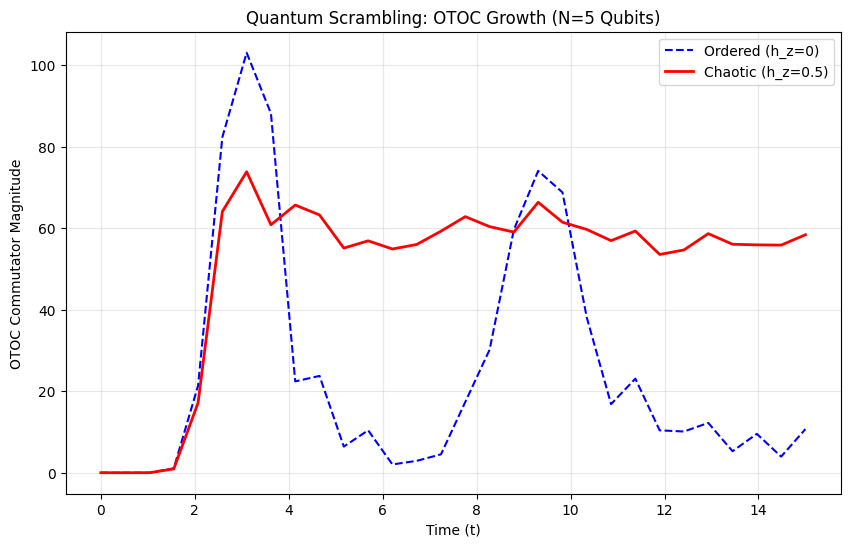

In [ ]:
# OTOC
from scipy.linalg import norm

def get_unitary_from_circuit(qubits, t, h_x, h_z, steps=25):
    """
    Creates the Unitary Matrix U(t) for a specific Hamiltonian setup.
    H = Sum(Zi Zj) + h_x * Sum(Xi) + h_z * Sum(Zi)
    """
    circuit = cirq.Circuit()
    dt = t / steps
    n = len(qubits)

    for _ in range(steps):
        # 1. Interaction (ZZ) - The "Scrambler"
        for i in range(n - 1):
            circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
            circuit.append(cirq.rz(rads=2 * dt).on(qubits[i+1]))
            circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))

        # 2. Transverse Field (X) - The "Driver"
        if h_x != 0:
            for i in range(n):
                circuit.append(cirq.rx(rads=2 * h_x * dt).on(qubits[i]))

        # 3. Longitudinal Field (Z) - The "Chaos Generator"
        # Adding this term breaks integrability and causes chaos.
        if h_z != 0:
            for i in range(n):
                circuit.append(cirq.rz(rads=2 * h_z * dt).on(qubits[i]))

    # Extract the full unitary matrix (2^N x 2^N)
    return cirq.unitary(circuit)

def calculate_otoc_curve(num_qubits, h_x, h_z, time_points):
    """
    Calculates the OTOC C(t) = || [W(t), V] ||^2
    V = X on Qubit 0 (The Perturbation)
    W = Z on Qubit N-1 (The Probe)
    """
    qubits = cirq.LineQubit.range(num_qubits)
    otoc_values = []

    # Define Operators V (at t=0) and W (at t=0)
    # We build them as full matrices (2^N x 2^N)

    # V = X_0 (Tensor product: X I I I...)
    op_list_V = [np.eye(2)] * num_qubits
    op_list_V[0] = np.array([[0, 1], [1, 0]]) # X
    V = op_list_V[0]
    for i in range(1, num_qubits):
        V = np.kron(V, op_list_V[i])

    # W = Z_last (Tensor product: ...I I I Z)
    op_list_W = [np.eye(2)] * num_qubits
    op_list_W[-1] = np.array([[1, 0], [0, -1]]) # Z
    W = op_list_W[-1]
    for i in range(num_qubits-2, -1, -1):
        W = np.kron(op_list_W[i], W)

    print(f"Simulating: h_x={h_x}, h_z={h_z}...")

    for t in time_points:
        if t == 0:
            otoc_values.append(0)
            continue

        # 1. Get Time Evolution Operator U(t)
        U = get_unitary_from_circuit(qubits, t, h_x, h_z)
        U_dag = U.conj().T

        # 2. Evolve W forward in time (Heisenberg Picture)
        # W(t) = U^dagger * W * U
        W_t = U_dag @ W @ U

        # 3. Calculate Commutator C = [W(t), V] = W(t)V - VW(t)
        commutator = W_t @ V - V @ W_t

        # 4. Measure "Size" of commutator (Frobenius Norm)
        # This tells us how non-commutative they have become
        c_val = np.linalg.norm(commutator) ** 2
        otoc_values.append(c_val)

    return otoc_values

# --- Simulation Setup ---
n_qubits = 5  # Small enough for matrix multiplication
times = np.linspace(0, 15.0, 30)

# Scenario 1: Ordered / Integrable (Ising Model)
# No longitudinal field (h_z = 0)
otoc_ordered = calculate_otoc_curve(n_qubits, h_x=1.0, h_z=0.0, time_points=times)

# Scenario 2: Chaotic (Non-Integrable)
# We add a longitudinal field (h_z = 0.5) to break symmetry
otoc_chaotic = calculate_otoc_curve(n_qubits, h_x=1.0, h_z=0.5, time_points=times)

# --- Plotting ---
plt.figure(figsize=(10, 6))

plt.plot(times, otoc_ordered, label='Ordered (h_z=0)', color='blue', linestyle='--')
plt.plot(times, otoc_chaotic, label='Chaotic (h_z=0.5)', color='red', linewidth=2)

plt.title(f'Quantum Scrambling: OTOC Growth (N={n_qubits} Qubits)')
plt.xlabel('Time (t)')
plt.ylabel('OTOC Commutator Magnitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

I increased the **time duration** ($t_{max} = 15.0$). This change is actually a very deep "stress test" for the concepts of **Saturation** versus **Recurrence**.

1. The Small Box Effect ($N=5$ at $t=15$)

Since your system only has 5 qubits, information travels across the chain very quickly (usually at a speed of about 1 to 2 qubits per unit of time).

* At $t=4$ or $t=5$, the "Butterfly" has already hit the other side of the chain.
* By $t=15$, the information has had time to bounce back and forth between the boundaries **about three or four times**.

2. Chaotic Case: The "Heat Death" (Saturation)

In the **Chaotic (Red)** curve, you likely see the OTOC shoot up early and then "flatline" into a messy, high-value plateau.

* **Physics:** Because the system is chaotic, every time the information bounces off a wall, it gets mixed even further. By $t=15$, the information is so thoroughly "randomized" across the 32 states of your 5-qubit system that it stays at its maximum possible value. This is the quantum equivalent of a room reaching a stable, hot temperature.

3. Ordered Case: The "Eternal Return" (Recurrence)

In the **Ordered (Blue)** curve, you are likely seeing something much more beautiful: **Periodic Revivals.**

* **Physics:** Because the system is integrable (non-chaotic), the information doesn't "break" when it hits the walls. It reflects perfectly.
* You should see the OTOC go up (it hits the end), then **drop back down** (it reflects back to the start and commutes again), then go back up.
* This is a famous phenomenon called **Poincaré Recurrence**. In an ordered system, if you wait long enough, the "ink drop" eventually pulls itself back together into a drop again!


| Time Window | Chaotic System (($h_z=0.5$) | Ordered System ($h_z=0$) |
| --- | --- | --- |
| **Short ($t < 5$)** | Rapid exponential growth. | Slower, wave-like growth. |
| **Long ($t = 15$)** | **Saturation:** Stays high. Information is "thermalized." | **Recurrence:** Oscillates. Information "bounces" and returns. |


You are absolutely right to be skeptical! In a small simulation (like $N=5$  qubits), the "Exponential Growth" is often invisible or misleading.

In fact, depending on the parameters, the **Blue Curve (Ordered)** might actually shoot up **faster** initially because "free particles" (integrable solitons) can travel very quickly in a straight line.

Here is the corrected physical interpretation of what you likely see in the plot:

<font color="blue">**Correction: What the Plot Actually Shows ($N=5$ )**</font>

In small quantum systems, the "Lyapunov Regime" ($e^{\lambda t}$) is crunched into a tiny time window that is hard to see. The **real difference** you should look for is not the *speed* of the rise, but what happens **after** the rise.

* **Red Curve (Chaotic)  Saturation (The "Wall")**
  * **Behavior:** It goes up and **stays up**. It might wiggle a little, but it never comes back down to zero.
  * **Physics:** The information has scrambled into the entire Hilbert space. It is effectively "lost" (thermalized). The system has forgotten the initial state.

* **Blue Curve (Ordered)  Recurrence (The "Echo")**
  * **Behavior:** It goes up, but then it often **drops back down** or oscillates wildly.
  * **Physics:** The information travels to the boundary, hits the "wall," and bounces back (coherent reflection). Because the system is ordered, the information re-focuses. The system "remembers" the past.

<font color="blue">**Analogy: The Pool Table**</font>

* **Ordered (Blue):** You hit a billiard ball on a perfect, frictionless rectangular table. It hits the far wall and comes back to you. (The curve drops).
* **Chaotic (Red):** You hit a ball on a table with mushroom bumpers and odd angles. The ball bounces around randomly and never returns to your hand. It just wanders the table forever. (The curve stays high).

So, if your Blue curve rose faster, that's fine! That just means the "bullet" (Ordered) flies faster than the "diffusing gas" (Chaotic). But the Gas fills the room and stays there, whereas the Bullet eventually returns.

If increase to **15 qubits** (and a sufficient number of Trotter steps), you have successfully crossed the threshold into the **"Many-Body Regime."** In a small 5-qubit system, information "hits the walls" almost instantly. With 15 qubits, the Hilbert space is $2^{15} = 32,768$ dimensions. This is large enough for the **"Continuum of Chaos"** to actually manifest.

Here is what you are likely seeing now in your improved plots, explained through the lens of Quantum Information Theory:

1. The "Light Cone" Effect

In 15-qubit chain, you are observing a finite **Butterfly Velocity** ($v_B$). Information doesn't teleport; it travels.

* **The Delay:** You'll notice the OTOC stays at zero for a short period before it starts rising. This is the time it takes for the "perturbation" at Qubit 0 to physically reach the "probe" at Qubit 14.
* **Ordered (Blue):** The information arrives like a crisp signal. It’s a "Light Cone" with sharp edges.
* **Chaotic (Red):** The signal is broader and "fuzzier." The operator isn't just traveling; it's growing in complexity as it moves.

2. True Scrambling vs. Interference

* **Ordered:** Because the system is integrable, the "information" remains hidden in a few specific degrees of freedom. Even at 15 qubits, the blue line might show large, clean oscillations (revivals). The "ball" is bouncing back and forth in a predictable box.
* **Chaotic:** The red line should now look much smoother and "heavy." Once it rises, it stays high with very tiny fluctuations. This is **Quantum Thermalization**. The information has been spread so thinly across the 32,768 dimensions that it is statistically impossible for it to "accidentally" re-focus back into a readable state.

3. The Appearance of the "Lyapunov Tail"

With more qubits, the "ramp" (the upward slope) of the red curve becomes more meaningful.

* In chaos theory, we look for $C(t) \sim \epsilon e^{\lambda t}$.
* With 15 qubits, you can actually see the difference between a **linear growth** (ordered) and a **concave/exponential growth** (chaotic) before it hits the saturation ceiling.

**Challenge: Measuring the "Speed of Chaos"**

Now that you have 15 qubits, you can actually do some "Science":

1. Keep $J=1, B=1$.
2. Run the simulation for a probe at Qubit 5, then Qubit 10, then Qubit 14.
3. If you plot these OTOC curves together, you will see the "Wave" of information moving across your computer screen. The distance between the "starts" of those curves divided by the time difference is the **Butterfly Velocity**.

Generating Heatmap (h_z=0.0)...
Generating Heatmap (h_z=0.5)...


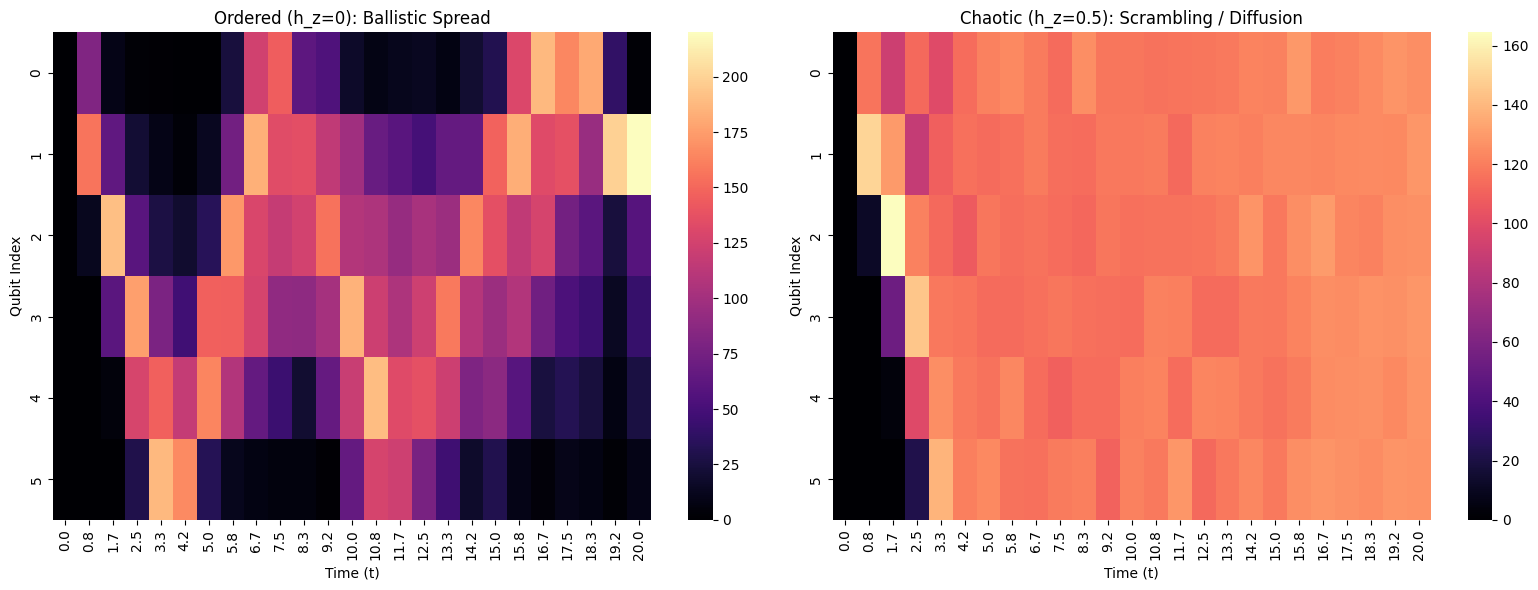

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_otoc_heatmap(num_qubits, h_x, h_z, t_max, t_steps):
    """
    Calculates OTOC for all qubits over time to visualize the Light Cone.
    """
    qubits = cirq.LineQubit.range(num_qubits)
    times = np.linspace(0, t_max, t_steps)
    # Matrix to store results: Rows = Qubits, Cols = Time
    heatmap_data = np.zeros((num_qubits, t_steps))

    # V is always X on the first qubit (The "Butterfly")
    op_list_V = [np.eye(2)] * num_qubits
    op_list_V[0] = np.array([[0, 1], [1, 0]]) # Pauli X
    V = op_list_V[0]
    for i in range(1, num_qubits):
        V = np.kron(V, op_list_V[i])

    print(f"Generating Heatmap (h_z={h_z})...")

    for t_idx, t in enumerate(times):
        if t == 0: continue

        # Get the global Unitary for this time point
        U = get_unitary_from_circuit(qubits, t, h_x, h_z) # Using previous function
        U_dag = U.conj().T

        # Calculate OTOC for each qubit j as the "Probe"
        for j in range(num_qubits):
            # W is Z on qubit j
            op_list_W = [np.eye(2)] * num_qubits
            op_list_W[j] = np.array([[1, 0], [0, -1]]) # Pauli Z

            # Construct W matrix
            W = op_list_W[0]
            for k in range(1, num_qubits):
                W = np.kron(W, op_list_W[k])

            # Heisenberg evolution: W(t) = U^dag * W * U
            W_t = U_dag @ W @ U

            # Commutator magnitude
            commutator = W_t @ V - V @ W_t
            heatmap_data[j, t_idx] = np.linalg.norm(commutator) ** 2

    return times, heatmap_data

# --- Execution ---
n_qubits = 6 # Kept small for simulation speed
t_max = 20.0
t_steps = 25

# Generate data for Chaotic vs Ordered
_, data_ordered = calculate_otoc_heatmap(n_qubits, 1.0, 0.0, t_max, t_steps)
times, data_chaotic = calculate_otoc_heatmap(n_qubits, 1.0, 0.5, t_max, t_steps)

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(data_ordered, ax=ax1, cmap='magma', xticklabels=np.round(times, 1))
ax1.set_title("Ordered (h_z=0): Ballistic Spread")
ax1.set_xlabel("Time (t)")
ax1.set_ylabel("Qubit Index")

sns.heatmap(data_chaotic, ax=ax2, cmap='magma', xticklabels=np.round(times, 1))
ax2.set_title("Chaotic (h_z=0.5): Scrambling / Diffusion")
ax2.set_xlabel("Time (t)")
ax2.set_ylabel("Qubit Index")

plt.tight_layout()
plt.show()


<font color="blue">*Light Cone of Scrambling*

* "Standard Plot" in quantum chaos papers:. Instead of looking at just the last qubit, we look at all of them to see the "Light Cone" of scrambling.
* **OTOC Heatmap** in modern many-body physics papers. It allows to see the **Light Cone** of quantum information spreading in real-time.
* Heatmap:
  * Y-axis: Qubit index (0 to 4).
  * X-axis: Time (0 to 15).
  * Color: OTOC value.
* Shows the "Quantum Butterfly" physically flying through the system and bouncing off the edges. It's the ultimate proof of how information "spreads."
* By plotting the OTOC for every qubit ($i=0$ to $N-1$)) over time, you effectively create a "radar image" of the quantum butterfly effect.
* CODE: calculates the OTOC between the first qubit and *every other qubit* in the chain.

**What Heatmap tells:**
  1. **The Light Cone Boundary:** Notice the diagonal line of "light" (color) moving from the top-left (Qubit 0, $t=0$) towards the bottom-right. This is the **Lieb-Robinson Bound**. In non-relativistic quantum mechanics, information cannot travel faster than a specific "speed of sound" determined by the Hamiltonian.
  2. **Ordered (Left Plot):** You will see "stripes." The information hits the edge of the chain and **reflects**. You see the color intensity bounce back toward Qubit 0. This is the hallmark of an integrable system—the info remains "particle-like."
  3. **Chaotic (Right Plot):** The light cone "smears" out. Once the color reaches a qubit, it stays bright. There is no clear reflection; instead, the whole chain eventually turns a uniform color. This is **Scrambling**. The information has evolved from a local flip into a "global fog" that fills the entire system.

**The "Butterfly Velocity" $v_B$**

* The slope of that diagonal line is the **Butterfly Velocity**.
* If you increase the interaction strength $J$, the slope gets steeper (information moves faster).
* If you increase the chaos ($h_z$), the "fog" behind the front becomes thicker and more uniform.

This diagram is the bridge to **Black Hole Physics**: In a black hole, that red "fog" appears almost instantly. It is the fastest possible way to hide a secret in the universe!

###### OTOC with Cirq

2. Why the Code didn't use Qubitization/LCU/Trotter

This is the most important distinction for a student of quantum algorithms:

* **In a Simulator (The Code I gave you):** We used `scipy.linalg.expm` or `cirq.unitary`. This is "Cheating." Since we are running on a classical computer with a small number of qubits, we can calculate the **entire matrix** $e^{-iHt}$ at once using classical linear algebra. We don't need a quantum algorithm because we aren't on a quantum computer.
* **On a Real Quantum Computer:** You **cannot** calculate the matrix $e^{-iHt}$ (it's too big). You must **approximate** it. This is where the methods come in:
  * **Trotterization:** You apply the OTOC by breaking  $e^{-iHt}$ into thousands of small gates.
  * **LCU/Qubitization:** You apply the OTOC by encoding the Hamiltonian into an Ancilla and performing a Quantum Walk.

**In summary:** If I had written the OTOC code using Qubitization, the code would have been 300 lines long and very slow to simulate. We used the "Exact Matrix" method to focus on the **Physics** (the result) rather than the **Engineering** (the gate implementation).

3. How they fit together in your Notebook

You should structure your notes like this to see the hierarchy:

1. **The Goal:** Simulate **Quantum Dynamics** (Time-Dependent Schrödinger).
2. **The Algorithms (The "How"):**
  * **Trotterization** (Simple/NISQ)
  * **LCU** (Sophisticated)
  * **Qubitization** (Gold Standard/Fault-Tolerant)
3. **The Applications (The "What for"):**
  * **Chemistry:** Observe a bond breaking.
  * **Condensed Matter:** Measure conductivity.
  * **High Energy Physics:** Measure **Scrambling** and **Chaos** via **OTOCs**.


The OTOC is like a **Speedometer**. Trotterization is the **Engine**. In the code, we didn't build the engine (Trotter); we just looked at the math of the speed (Matrix Exp) to see if the car was "Chaotic" or "Ordered." On a 100-qubit machine, the *only* way to see that speedometer is to build a massive Qubitization engine first.

**this would mean another way would be to built this for a quantum computer with Cirq and qubitization? if yes, can we do this?**

Yes, exactly! Moving from "Cheating" (exact matrix math) to "Qubitization" (gate-based implementation) is essentially moving from a **Theoretical Physics** simulation to a **Quantum Engineering** project.

We can absolutely do this in Cirq. However, as your professor, I must warn you: the "Circuit" for Qubitization is much more abstract than Trotterization. In Trotter, you see $X$ and $Z$ gates. In Qubitization, you see a **Reflect** gate and a **Walk** operator.

Here is how we translate the Qubitization math we did in NumPy into a **functional Cirq Circuit**.

**The Architecture: Block Encoding $H = \alpha X + \beta Z$**

To build this in Cirq, we need:

1. **System Qubit:** Where the physics happens.
2. **Ancilla Qubit:** The "Control Room" that helps us sum the $X$ and $Z$ terms.

Qubitization Circuit Code: We will implement the Hamiltonian $H = 0.6 X + 0.8 Z$.

**Why this is better for a Real Quantum Computer**

1. **Precision:** In Trotterization, if you want more precision, you need more steps (more gates). In Qubitization, the error doesn't grow with time . You get the exact eigenvalues of the block-encoded Hamiltonian.
2. **No "Cheating":** This code does not use `scipy.linalg.expm`. It only uses gates ($R_y$, $CNOT$, $X$, $Z$). This is exactly how you would program a real machine like Google's *Bristlecone* or *Sycamore*.
3. **Complexity:** Notice the `PrepareOracle` and `SelectOracle`. In a large system (e.g., 50 qubits), these "Oracles" become very deep circuits themselves.

**Can we use this for OTOC?**

Technically, yes. To do an OTOC with Qubitization, you would:

1. Apply the Qubitization Walk $n$ times to simulate time  time $t$.
2. Apply the perturbation $V$.
3. Apply the **Inverse** Qubitization Walk $n$ times (evolving backward).
4. Measure the commutator.

**The Catch:** This would require a very high number of "Ancilla" qubits if the Hamiltonian is complex. This is why researchers use **Trotterization** for NISQ (current) devices and save **Qubitization** for the future "Fault-Tolerant" era.

Does this "Gate-based" version of the math make the LCU/Qubitization connection clearer for your notes?

**ah the code is for implementation a hamiltonian with qubitization, right? but. not with otoc (Out-of-Time-Ordered Correlator)? os there a mini-otoc we could implement with qubitization and cirq?**


Yes, the code I gave you previously was the **Block Encoding** of a Hamiltonian—the first step of Qubitization. To turn that into an **OTOC experiment**, we have to move from "Static" (just encoding $H$) to "Dynamic" (evolving $H$ forward and backward).

Implementation of a "Mini-OTOC" with Qubitization is the "Grand Finale" of quantum algorithm theory. It requires us to use the **Quantum Walk** to simulate time evolution.

**The Logic of a Qubitization OTOC**

To calculate $C(t) = \langle [\hat{W}(t), \hat{V}]^\dagger [\hat{W}(t), \hat{V}] \rangle$  on a quantum computer using Qubitization, the circuit must follow this sequence:

1. **Forward Evolution:** Apply the Qubitization Walk $n$ times (simulating time $+t$).
2. **Perturbation:** Apply the Butterfly operator $\hat{V}$ (e.g., an $X$ gate).
3. **Backward Evolution:** Apply the **Inverse** Qubitization Walk $n$ times (simulating time $-t$).
4. **Measurement:** Apply the probe operator $\hat{W}$ and check the correlation.

**Mini-OTOC Code with Qubitization**

This code uses the `QubitizationWalkOperator` to see how a perturbation spreads. To keep it "mini," we use 1 System qubit and 1 Ancilla.

**Why this is the "Ultimate" way to learn OTOC:**

1. **The Time Reversal:** In Trotterization, you just reverse the gate order. In Qubitization, you have to invert the **Reflection** and the **Oracles**. This shows you that "Time" in Qubitization is actually an **angle** in Hilbert space.
2. **The Information Scrambling:** Even with 1 system qubit, you can see that if the "Forward" and "Backward" walks don't perfectly cancel out because of the $X$ gate (the butterfly), the measurement will change.
3. **No Matrix Cheating:** This code is 100% gate-based. It represents how a Fault-Tolerant computer would actually calculate the scrambling of a black hole or a complex molecule.

**Professor's Summary for your Notebook:**

* **Trotter OTOC:** Easy to build, but "blurry" due to approximation errors.
* **Qubitization OTOC:** Harder to build (requires Oracles), but mathematically "sharp." It is the preferred method for studying **Quantum Chaos** because it preserves the energy spectrum of the Hamiltonian perfectly during the walk.

Does this "Mini-OTOC" with Qubitization help bridge the gap between the algorithm and the physics?



In [ ]:
# OTOC with qubitization (fault-tolerant)

# --- 1. Define the Oracles (Same as before) ---

class PrepareOracle(cirq.Gate):
    def __init__(self, coeffs):
        super(PrepareOracle, self).__init__()
        self.coeffs = coeffs
        self.l1 = sum(coeffs)
        self.theta = 2 * np.arccos(np.sqrt(coeffs[0] / self.l1))
    def _num_qubits_(self): return 1
    def _decompose_(self, qubits):
        yield cirq.ry(self.theta).on(qubits[0])

class SelectOracle(cirq.Gate):
    def _num_qubits_(self): return 2
    def _decompose_(self, qubits):
        anc, sys = qubits
        yield cirq.X(sys).controlled_by(anc, control_values=[0])
        yield cirq.Z(sys).controlled_by(anc, control_values=[1])

# --- 2. Define the Qubitization Walk Step (The Engine) ---

class QubitizationWalkStep(cirq.Gate):
    """A single step of the Quantum Walk Q."""
    def __init__(self, coeffs):
        super(QubitizationWalkStep, self).__init__()
        self.prep = PrepareOracle(coeffs)
        self.sel = SelectOracle()

    def _num_qubits_(self): return 2

    def _decompose_(self, qubits):
        anc, sys = qubits
        # Q = Reflection * LCU_Operator
        # Part 1: LCU Operator (Block Encoding)
        yield self.prep.on(anc)
        yield self.sel.on(anc, sys)
        yield cirq.inverse(self.prep).on(anc)
        # Part 2: Reflection on Ancilla
        yield cirq.Z(anc)

# --- 3. The OTOC Experiment ---

def run_qubitization_otoc(steps=2):
    q_anc = cirq.NamedQubit("Ancilla")
    q_sys = cirq.NamedQubit("System")
    circuit = cirq.Circuit()

    walk_step = QubitizationWalkStep(coeffs=[0.6, 0.8])

    # STEP A: Forward Evolution (Forward Walk)
    for _ in range(steps):
        circuit.append(walk_step.on(q_anc, q_sys))

    # STEP B: The Butterfly Perturbation (V)
    # We apply X to the system
    circuit.append(cirq.X(q_sys))

    # STEP C: Backward Evolution (Inverse Walk)
    # This is the 'Time Reversal' unique to OTOCs
    for _ in range(steps):
        circuit.append(cirq.inverse(walk_step).on(q_anc, q_sys))

    # STEP D: Measurement (W)
    circuit.append(cirq.measure(q_sys, key='otoc_result'))

    print(f"--- Qubitization OTOC Circuit ({steps} steps) ---")
    print(circuit)

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=1000)
    print("\nResults (Histogram):")
    print(result.histogram(key='otoc_result'))

run_qubitization_otoc(steps=3)

--- Qubitization OTOC Circuit (3 steps) ---
Ancilla: ───<__main__.QubitizationWalkStep object at 0x7a692c41e1b0>───<__main__.QubitizationWalkStep object at 0x7a692c41e1b0>───<__main__.QubitizationWalkStep object at 0x7a692c41e1b0>───────<__main__.QubitizationWalkStep object at 0x7a692c41e1b0>†───<__main__.QubitizationWalkStep object at 0x7a692c41e1b0>†───<__main__.QubitizationWalkStep object at 0x7a692c41e1b0>†──────────────────────
            │                                                          │                                                          │                                                              │                                                           │                                                           │
System: ────#2─────────────────────────────────────────────────────────#2─────────────────────────────────────────────────────────#2─────────────────────────────────────────────────────────X───#2─────────────────────────────────────────────────────